# Brazillian E-Commerce by Olyst
- **Analysis and visualization of orders (delayed or not) and customer reviews**
![](https://zoomentregas.com.br/wp-content/uploads/2021/03/2021-03-17-entrega-no-mesmo-dia.jpg)

In [1]:
# importing the libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import sqlite3
import datetime as dt
from wordcloud import WordCloud

In [2]:
# making a connection with the database

conn = sqlite3.connect("brazilian_ecommerce_sales.db")

In [3]:
cur = conn.cursor()

In [4]:
def execute(cod):
    '''
    cod = code in SQL to query the database
    '''
    
    # returning all rows from the database query
    df = cur.execute(cod).fetchall()
    
    # transforming it into a dataframe 
    df = pd.DataFrame(df)
    
    # atribuying the name of columns
    if df.shape[1] > 0:
        df.columns = [col[0] for col in cur.description]
        
    # output
    return df

In [5]:
# checking the name of all tables from the database

execute('''
        SELECT 
            name
        FROM 
            sqlite_schema
        WHERE type = 'table'
        ''')

,name
0,customers
1,geolocation
2,orders
3,order_items
4,order_payments
5,order_reviews
6,products
7,sellers
8,product_category_name_translation


### Querying the database

In [6]:
# orders table

orders = execute('''
        SELECT
            *
        FROM
            orders
''')

orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


In [8]:
# changing the data type of date columns

for col in['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])

In [9]:
orders.order_delivered_customer_date - orders.order_estimated_delivery_date

0        -8 days +21:25:13
1        -6 days +15:27:45
2       -18 days +18:06:29
3       -13 days +00:28:42
4       -10 days +18:17:02
               ...        
99436   -11 days +15:08:01
99437    -2 days +17:37:56
99438    -6 days +11:24:17
99439   -21 days +23:32:54
99440   -18 days +13:08:30
Length: 99441, dtype: timedelta64[ns]

In [10]:
# creating a column with the number of days of delivery delay

orders['delivery_delay'] = (orders.order_delivered_customer_date - orders.order_estimated_delivery_date).dt.days

In [11]:
# creating a binary column containing 0 (there was no delay) and 1 (there was delay)

orders['delay'] = orders.delivery_delay.apply(lambda row : 0 if row <= 0 else 1)

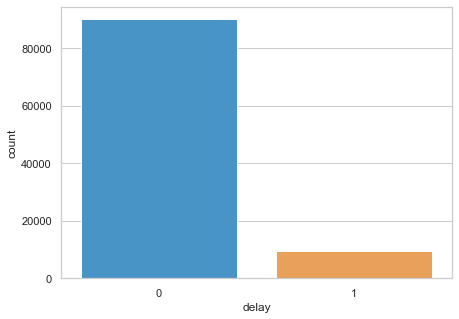

In [12]:
plt.figure(figsize=(7, 5))
sns.countplot(x=orders['delay'], palette=['#3498db', '#ff9f43']);

In [13]:
# creating a column containing the month and year of delivery

orders['month'] = orders.order_purchase_timestamp.dt.to_period('M')

In [14]:
orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delay,month
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8.0,0,2017-10
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6.0,0,2018-07
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18.0,0,2018-08
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13.0,0,2017-11
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10.0,0,2018-02


In [15]:
# counting the orders in each month

orders.groupby('month')['order_id'].count()

month
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: order_id, dtype: int64

In [16]:
orders[orders.month < '2017-01'].head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delay,month
324,324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09,NaN,1,2016-10
378,378,cbbb524a0e1646aa6cf7a3c0bbe517ad,dacb079d55ffb1d3955c5d923df3ebb7,delivered,2016-10-05 07:31:49,2016-10-06 02:46:24,2016-10-10 02:46:24,2016-10-16 14:36:00,2016-12-07,-52.0,0,2016-10
699,699,ac2b7c522d811acba0aa270ed3e112e4,ef21aebbb093a6db29ccc6aa0b89c347,delivered,2016-10-05 15:08:00,2016-10-06 15:44:26,2016-10-10 15:44:27,2016-10-13 15:44:27,2016-11-29,-47.0,0,2016-10
1384,1384,7033745709b7cf1bac7d2533663592de,7f0ca17bb33b230b47459437cf0682c7,delivered,2016-10-04 14:13:22,2016-10-04 14:46:48,2016-10-08 14:46:49,2016-10-11 14:46:49,2016-11-30,-50.0,0,2016-10
1449,1449,5cd498954e2b37d71b315166809b4bd7,ff1a56726b7ea149c7423865609cc0c8,delivered,2016-10-07 00:54:40,2016-10-08 03:56:15,2016-10-25 11:35:52,2016-10-27 17:32:07,2016-12-01,-35.0,0,2016-10


In [17]:
orders[orders.month > '2018-08'].head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,delay,month
1801,1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,NaN,1,2018-09
5149,5149,ea844c92cf978ea23321fa7fe5871761,6ddc45ad08e6a2c885ca2255fc52d6df,canceled,2018-09-13 09:56:12,NaT,NaT,NaT,2018-09-27,NaN,1,2018-09
9976,9976,87ae60ef8b08ae0e5f903cacb53a6904,fea4d57ed3a45455f89c25ef3dae8ee8,canceled,2018-09-11 16:45:54,NaT,NaT,NaT,2018-09-26,NaN,1,2018-09
16366,16366,bd35b677fd239386e9861d11ae98ab56,ad2eb5d02c0808bcd8743117f6383cf6,canceled,2018-09-17 17:21:16,NaT,NaT,NaT,2018-10-01,NaN,1,2018-09
20778,20778,4d59cc2a2e7bb6c0a851725f5888a9b5,ead83a4f8f7be8c3034b2e98754a6147,canceled,2018-09-06 14:50:07,NaT,NaT,NaT,2018-09-21,NaN,1,2018-09


In [18]:
# dropping these rows

orders.drop(orders.index[(orders.month < '2017-01') | (orders.month > '2018-08')], inplace=True)

**Now we can analyze the delivery delay for each month**

In [19]:
# counting the orders in each month again

orders_per_month = orders.groupby('month')['delay'].count()
orders_per_month

month
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
Freq: M, Name: delay, dtype: int64

In [20]:
delay_per_month = orders.groupby('month')['delay'].sum()

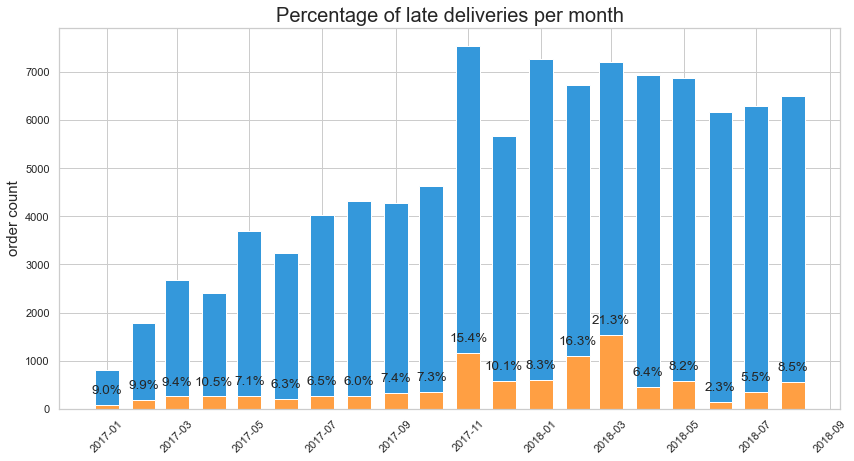

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(orders_per_month.index.to_timestamp(), orders_per_month.values, width=20, color='#3498db')
ax.bar(delay_per_month.index.to_timestamp(), delay_per_month.values, width=20, color='#ff9f43')

ax.set_title('Percentage of late deliveries per month', fontsize=20)
ax.set_ylabel('order count', fontsize=15)

ax.tick_params(axis='x', labelrotation = 45)

for i in range(0, len(delay_per_month)):
    ax.annotate(
            text= f"{(delay_per_month[i] * 100) / orders_per_month[i]:.1f}%",
            xy=(delay_per_month.index.to_timestamp()[i], delay_per_month.values[i]),
            fontsize=13.5,
            ha='center',
            va='top',
            xytext=(0, 20),
            textcoords='offset points'
    )

plt.show()

In [22]:
max_no_delay_month = orders.groupby('month')['delivery_delay'].min()
mean_delay_month = orders.groupby('month')['delivery_delay'].mean()
max_delay_month = orders.groupby('month')['delivery_delay'].max()

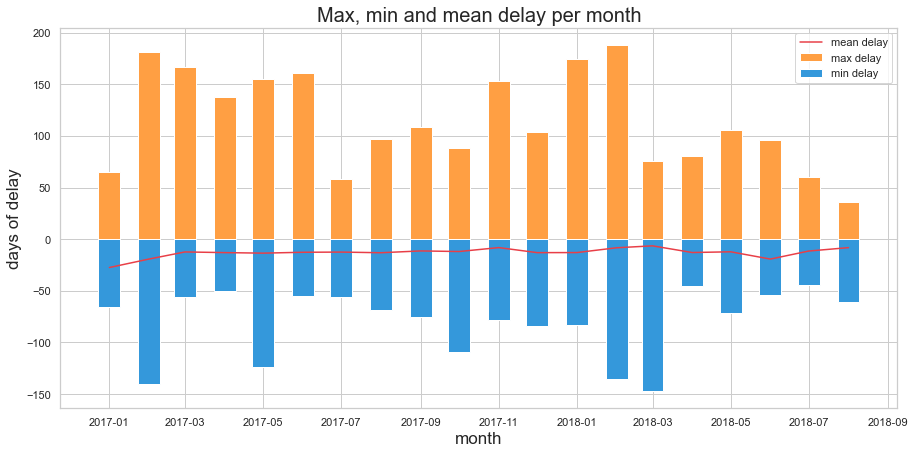

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(max_delay_month.index.to_timestamp(), max_delay_month.values, width=17, color='#ff9f43', label='max delay')
ax.bar(max_no_delay_month.index.to_timestamp(), max_no_delay_month.values, width=17, color='#3498db', label='min delay')
ax.plot(mean_delay_month.index.to_timestamp(), mean_delay_month.values, color='#e83f47', label='mean delay')

ax.set_xlabel('month', fontsize=17)
ax.set_ylabel('days of delay', fontsize=17)
ax.set_title('Max, min and mean delay per month', fontsize=20)

plt.legend()
plt.show()

it is possible to observe that the delay of orders is of such importance, even having absurd values ​​above 100 days of delay

Now we can analize the table of reviews

In [24]:
execute('''
        SELECT * FROM order_reviews
        ''').head()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [25]:
# using the INNER JOIN to concatening these tables

reviews = execute('''
        SELECT
            orders.order_id,
            order_delivered_customer_date,
            order_estimated_delivery_date,
            review_score,
            review_comment_message
        FROM
            orders
        INNER JOIN order_reviews
            ON orders.order_id = order_reviews.order_id
        ''')

reviews.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18 00:00:00,4,"Não testei o produto ainda, mas ele veio corre..."
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13 00:00:00,4,Muito bom o produto.
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04 00:00:00,5,None
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15 00:00:00,5,O produto foi exatamente o que eu esperava e e...
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26 00:00:00,5,None


In [26]:
for i in ['order_delivered_customer_date', 'order_estimated_delivery_date']:
    reviews[i] = pd.to_datetime(reviews[i])

In [27]:
reviews['delivery_delay'] = (reviews.order_delivered_customer_date - reviews.order_estimated_delivery_date).dt.days

In [28]:
reviews['delay'] = reviews.delivery_delay.apply(lambda row: 0 if row <= 0 else 1)

In [29]:
reviews['month'] = reviews.order_delivered_customer_date.dt.to_period('M')

In [30]:
reviews.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,delivery_delay,delay,month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,4,"Não testei o produto ainda, mas ele veio corre...",-8.0,0,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,4,Muito bom o produto.,-6.0,0,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,5,None,-18.0,0,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,5,O produto foi exatamente o que eu esperava e e...,-13.0,0,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,5,None,-10.0,0,2018-02


In [31]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99224 non-null  object        
 1   order_delivered_customer_date  96359 non-null  datetime64[ns]
 2   order_estimated_delivery_date  99224 non-null  datetime64[ns]
 3   review_score                   99224 non-null  int64         
 4   review_comment_message         40977 non-null  object        
 5   delivery_delay                 96359 non-null  float64       
 6   delay                          99224 non-null  int64         
 7   month                          96359 non-null  period[M]     
dtypes: datetime64[ns](2), float64(1), int64(2), object(2), period[M](1)
memory usage: 6.1+ MB


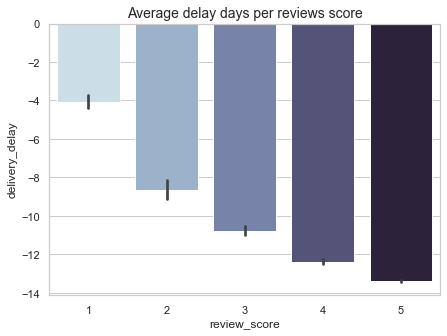

In [32]:
plt.figure(figsize=(7, 5))

plt.title('Average delay days per reviews score', fontsize=14)

sns.barplot(data=reviews, x='review_score', y='delivery_delay', palette='ch:s=.25,rot=-.25')
plt.show()

the longer the order delivery time, the lower the score.

In [33]:
delay_0 = reviews[reviews.delay == 0].groupby('review_score')['delay'].count().reset_index()

In [34]:
delay_1 = reviews[reviews.delay == 1].groupby('review_score')['delay'].count().reset_index()

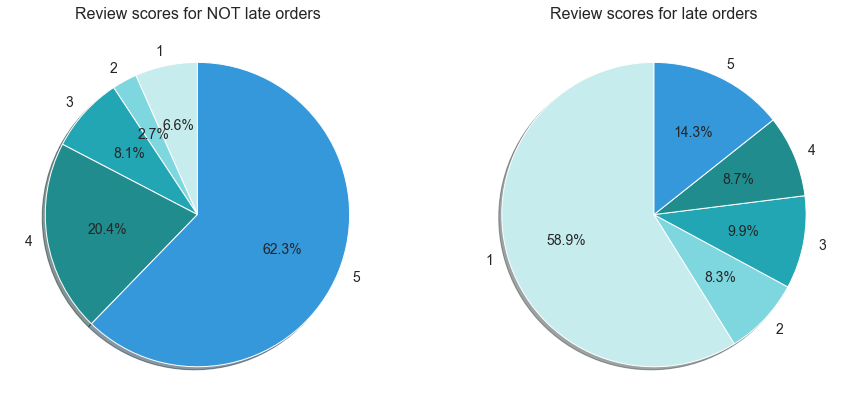

In [35]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)

colors=['#c7ecee', '#7ed6df', '#22a6b3', '#218c8d', '#3498db']
explode=[0.05, 0, 0, 0, 0]

ax[0].pie(x=delay_0['delay'].values, labels=delay_0['review_score'], autopct='%1.1f%%',
          colors=colors, shadow=True, startangle=90, textprops={'fontsize': 14})
ax[1].pie(x=delay_1['delay'].values, labels=delay_1['review_score'], autopct='%1.1f%%',
          colors=colors, shadow=True, startangle=90, textprops={'fontsize': 14})

ax[0].set_title('Review scores for NOT late orders', fontsize=16)
ax[1].set_title('Review scores for late orders', fontsize=16)

plt.show()

**pie charts confirm order score correlates with order delay**

In [36]:
comments = reviews.loc[(reviews.review_comment_message.notnull()) & (reviews.delay == 1), 'review_comment_message'].values

In [37]:
text = ' '
for txt in comments:
    text += txt + ' '
text = text.replace(',', '').replace('.', '').lower()
print(f'there\'re {len(text)} caracteres in the text')

there're 493200 caracteres in the text


## WordCloud

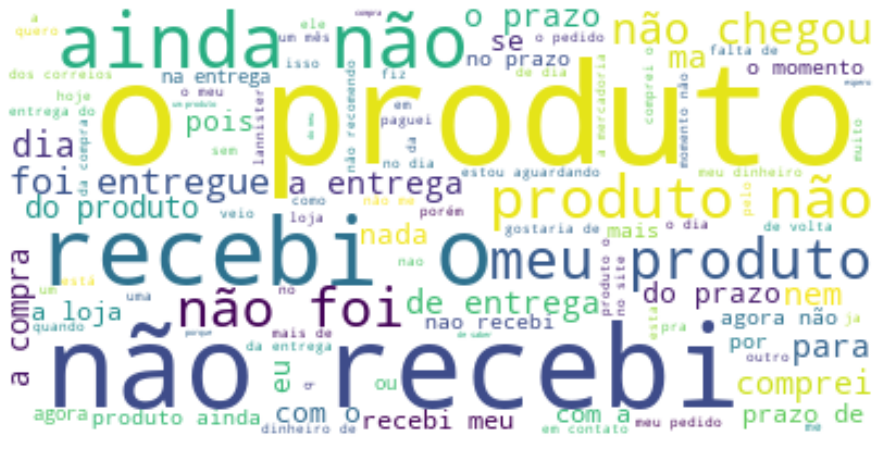

In [38]:
stopwords = ['que', 'o que', 'já', 'e', 'é', 'só', 'até']
wordcloud = WordCloud(background_color='white', max_words=100, stopwords=stopwords).generate(text)

plt.figure(figsize=(16, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()